## To Do

* Posterior predictive sampling
    * Univariate families **DONE**
    * Multivariate families **IN PROGRESS**
* Model string representation **NOT STARTED**
* Model aliases **IN PROGRESS**
    * Aliases work for predictors of both non-distributional and distributional models **DONE**
    * Make sure alias of response name is used in predictions **NOT STARTED**

## Examples working

* `alternative_links_binary.ipynb`
* `beta_regression.ipynb`
    * TypeError: Encountered error in ELPD computation of compare.
* `circular_regression.ipynb`
* `ESCS_multiple_regression.ipynb`
    * Needs updates because of old API
* `getting_started.ipynb`
    * Needs to update the Family part
* `hierarchical_binomial_bambi.ipynb`
    * Works but needs to update a dim name
* `logistic_regression.ipynb`
* `model_comparison.ipynb`
* `multi-level_regression.ipynb`
* `negative_binomial.ipynb`
* `radon_example.ipynb`
    * xarray issues, not bambi related
* `shooter_crossed_random_ANOVA.ipynb`
* `sleepstudy.ipynb`
    * There's a xarray problem in a viz, not related to Bambi
* `splines_cherry_blossoms.ipynb`
    * Works, but needs updates because some things use old API
* `Strack_RRR_re_analysis.ipynb`
* `t_regression.ipynb`
* `t_test.ipynb`
* `wald_gamma_glm.ipynb`

## Examples not working

* `categorical_regression.ipynb`
    * Fixed posterior predictive sampling, but the order of categories is broken

In [ ]:
import bambi as bmb
import numpy as np
import pandas as pd

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=0.5, size=size)

# Add outliers
x_out = np.append(x, [0.1, 0.15, 0.2])
y_out = np.append(y, [8, 6, 9])

data = pd.DataFrame({
    "x": x_out, 
    "y": y_out
})

In [ ]:
t_model = bmb.Model("y ~ x", data, family="t", priors={"nu": 2})
t_model.build()
t_fitted = t_model.fit(draws=500)
#t_model.predict(t_fitted, kind="pps")

In [ ]:
t_model.predict(t_fitted, kind="pps")

---

# Documentation notes

## Names

The logic is `{parent}_{child}`. The exception is the linear predictor of the main parameter, which is only `{child}`.

```python
bmb.Formula(
    "y ~ 1 + x + z",
    "sigma ~ 1 + x"
)
```

* `Intercept`
* `x`
* `z`
* `y_sigma`, the sigma parameter in the normal likelihood
* `sigma_Intercept`
* `sigma_x`

### Potential improvements

What about using just `sigma` instead of `{response_name}_sigma`. The gain: cleaner names. The downside: This pattern could be a conflict in a small number of cases where the name of predictors match the name of parameters in the likelihood. It could be "fixed" easily, by double checking the names of the predictors before creating the model.

If we want to create markdown to later be used as source of quarto documents...

* https://stackoverflow.com/questions/36237477/python-docstrings-to-github-readme-md
* https://pypi.org/project/pydoc-markdown/

* BRING CONSTANT COMPONENT NAMES BACK
    * Yes or No?...

Migration guide... 

* What used to be `model.terms["name"]` is now `model.response_component.terms["name"]`.
* Correlated priors for group-specific terms are not supported anymore. They will be brought back in the future.

To Do

* `plot_cap()` works only for the mean now, it should work for all the parameters, and even with posterior predictive draws.

In [1]:
import bambi as bmb
import numpy as np
import pandas as pd

from bambi.plots import plot_cap

In [11]:
data = pd.read_csv("https://gist.githubusercontent.com/seankross/a412dfbd88b3db70b74b/raw/5f23f993cd87c283ce766e7ac6b329ee7cc2e1d1/mtcars.csv")
data.to_csv("mtcars.csv", index=False)

In [2]:
data = pd.read_csv("https://gist.githubusercontent.com/seankross/a412dfbd88b3db70b74b/raw/5f23f993cd87c283ce766e7ac6b329ee7cc2e1d1/mtcars.csv")
data["cyl"] = data["cyl"].replace({4: "low", 6: "medium", 8: "high"})
data["cyl"] = pd.Categorical(data["cyl"], categories=["low", "medium", "high"], ordered=True)
data["gear"] = data["gear"].replace({3: "A", 4: "B", 5: "C"})

In [3]:
model = bmb.Model("mpg ~ 0 + hp * wt + cyl + gear", data)
idata = model.fit(tune=500, draws=500, target_accept=0.9, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mpg_sigma, hp, wt, hp:wt, cyl, gear]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 24 seconds.


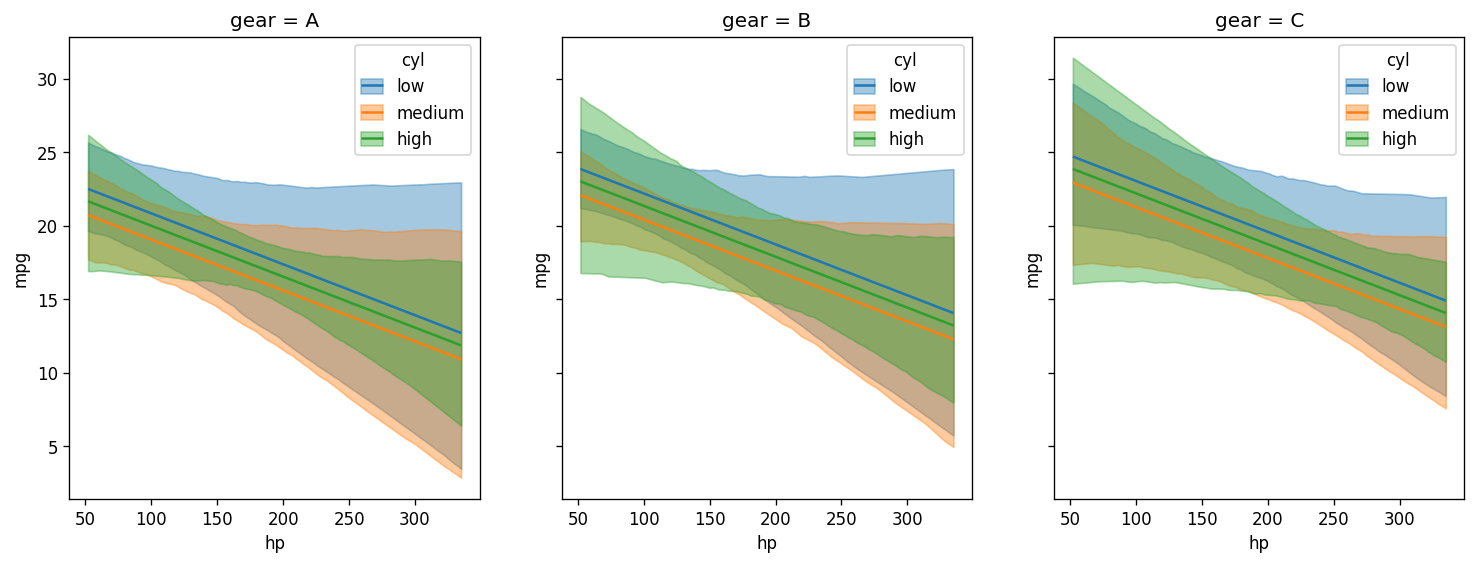

In [4]:
fig, axes = plot_cap(
    model, 
    idata, 
    {"horizontal": "hp", "color": "cyl","panel": "gear"},
    use_hdi=False, 
    fig_kwargs={"figsize": (15, 5), "dpi": 120, "sharey": True}
);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_y_sigma, Intercept, log_x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


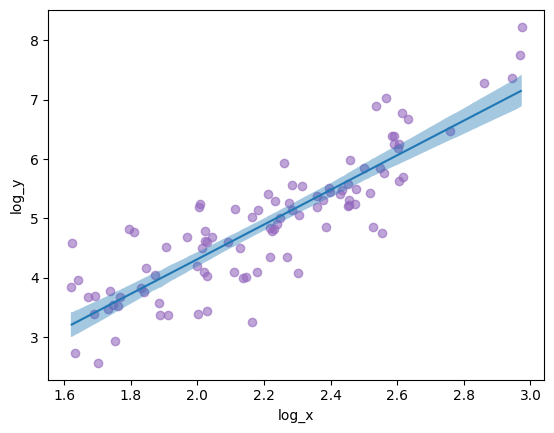

In [1]:
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bambi.plots import plot_cap

rng = np.random.default_rng(1234)
x = np.abs(rng.normal(size=100, scale=5)) + 5
y = np.exp(2 + 0.3 * x + rng.normal(size=100, scale=0.5))

data = pd.DataFrame({"x": x, "y": y})
data["log_x"] = np.log(x)
data["log_y"] = np.log(y)
model = bmb.Model("log_y ~ 1 + log_x", data)
idata = model.fit()

# Plot CAP on transformed scale. Result is a straight line
fig, ax = plt.subplots()
ax.scatter(data["log_x"], data["log_y"], color="C4", alpha=0.6);
plot_cap(model, idata, "log_x", ax=ax);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mpg_sigma, hp, cyl, hp:cyl, gear]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 16 seconds.


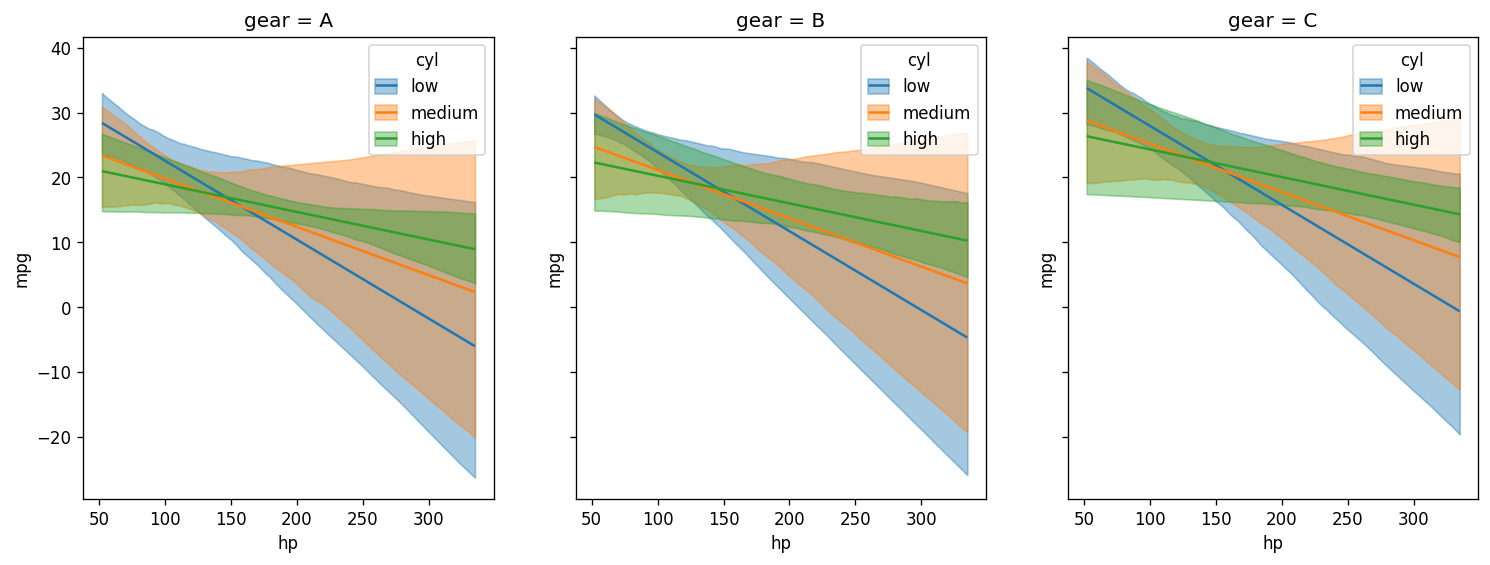

In [2]:
data = pd.read_csv("https://gist.githubusercontent.com/seankross/a412dfbd88b3db70b74b/raw/5f23f993cd87c283ce766e7ac6b329ee7cc2e1d1/mtcars.csv")
data["cyl"] = data["cyl"].replace({4: "low", 6: "medium", 8: "high"})
data["cyl"] = pd.Categorical(data["cyl"], categories=["low", "medium", "high"], ordered=True)
data["gear"] = data["gear"].replace({3: "A", 4: "B", 5: "C"})
model = bmb.Model("mpg ~ 0 + hp * cyl + gear", data)
idata = model.fit(tune=500, draws=500, random_seed=1234)

array([<AxesSubplot: xlabel='hp', ylabel='mpg'>], dtype=object)

True

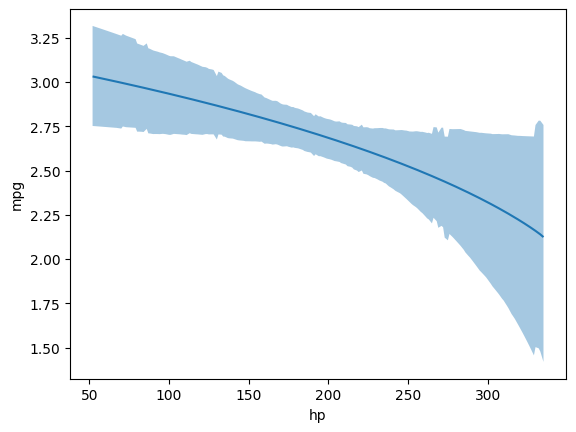

In [10]:
fig, axes = plot_cap(model, idata, ["hp"], transforms={"mpg": np.log});